# Import Libraries

In [28]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lazypredict.Supervised import LazyRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import folium
import random
from IPython.display import display

Display more decimals for pandas

In [2]:
pd.set_option('display.float_format', '{:.5f}'.format)

# Data Cleaning

In [101]:
# Import Data:
Ames_HousePrice = pd.read_csv('Ames_HousePrice.csv', index_col=0)
real_coords = pd.read_csv("real_estate_with_coordinates.csv")

# One row is duplicated in Ames_HousePrice df, once dropped there are no duplicate PID values
Ames_HousePrice = Ames_HousePrice.drop_duplicates()
real_coords = real_coords.drop_duplicates()

# Dataframe merging
real_estate_columns_to_keep = ['GeoRefNo','Prop_Addr', 'MA_Zip1','latitude', 'longitude']
housing_coords = pd.merge(Ames_HousePrice, real_coords[real_estate_columns_to_keep],
                               left_on='PID', right_on='GeoRefNo', how='left')

# Remove any duplicate rows created in merge
housing_coords = housing_coords.drop_duplicates()

# Remove outliers 528351010 has too high sale price, 908154205, has too much area
housing_coords = housing_coords[~housing_coords['PID'].isin([528351010, 908154205])]

# Drop Columns with too many NA Values
# housing_coords.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)

# Update missing gps data rows:
# housing_coords = housing_coords.dropna(subset=['latitude'])
mean_latitude = housing_coords['latitude'].mean()
housing_coords['latitude'].fillna(mean_latitude, inplace=True)

mean_longitude = housing_coords['longitude'].mean()
housing_coords['longitude'].fillna(mean_longitude, inplace=True)

# DistanceToISU column contains the distance of each property to Iowa State University
# Coordinates of Iowa State University
isu_latitude = 42.0239
isu_longitude = -93.6476
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    radius = 3958.8
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    # Differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Calculate the distance
    distance = radius * c
    return distance
# Calculate distance for each property address
housing_coords['DistanceToISU'] = housing_coords.apply(
    lambda row: haversine(row['latitude'], row['longitude'], isu_latitude, isu_longitude), axis=1)

# 2 rows with gps info but missing zip:
specified_addresses = ['2010 KILDEE ST', '1310 WOODSTOCK AVE']
# Update 'Zipcode' to 50014 where 'Address' is in the specified list
housing_coords.loc[housing_coords['Prop_Addr'].isin(specified_addresses), 'MA_Zip1'] = 50014
    
# 'Prop_Addr' column useful for EDA and data cleaning but not for modeling
housing_coords.drop('Prop_Addr',axis=1,inplace=True)

# Reset index after dropping rows so flitering by iloc works smoothly
housing_coords.reset_index(drop=True,inplace=True)

# This is good for EDA but since it is calculated from the target it will cause 
# data leakage and shouldn't be included in modeling
    # # Added PricePerSF Column
    # housing_coords['PricePerSF'] = housing_coords['SalePrice'] / housing_coords['GrLivArea']

# Delete utilities column, it has 2496/2497 with same value
    # housing_coords.Utilities.value_counts() # <-- No N/As here
housing_coords.drop('Utilities',axis=1,inplace=True)

# Fix Row with Missing Values in Basement Categories
housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
    'BsmtFullBath','BsmtHalfBath']] = housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(0)

# Masonry Veneer (Type/Area)
    # If Type = 'None' but Area != 0, Type updated to mode
    # N/As updated to None for Type and 0 for Area
idx = (housing_coords['MasVnrArea'].isna()) & (housing_coords['MasVnrType'].isna())
housing_coords.loc[idx, 'MasVnrArea'] = housing_coords.loc[idx, 'MasVnrArea'].fillna(0)
housing_coords.loc[idx, 'MasVnrType'] = housing_coords.loc[idx, 'MasVnrType'].fillna('None')
mode_MasVnrType = housing_coords.loc[housing_coords.MasVnrType!='None'].MasVnrType.mode()[0]
idx2 = (housing_coords['MasVnrArea']!=0) & (housing_coords['MasVnrType']== 'None')
housing_coords.loc[idx2, 'MasVnrType'] = housing_coords.loc[idx2, 'MasVnrType'].fillna(mode_MasVnrType)

# Fix Row with Missing Values in GarageCars & GarageArea Categories
idx3 = (housing_coords['GarageArea']!=0) & (housing_coords['GarageType']=='Detchd')
mean_GarageArea = round(housing_coords.loc[idx3, 'GarageArea'].mean())
housing_coords.loc[housing_coords.PID==910201180,'GarageArea'] = mean_GarageArea
idx4 = housing_coords['GarageType']=='Detchd'
mode_GarageCars = housing_coords.loc[idx4, 'GarageCars'].mode()[0]
housing_coords.loc[housing_coords.PID==910201180,'GarageCars'] = mode_GarageCars

# Fill GarageYrBlt to match Year House Was Built
housing_coords['GarageYrBlt'] = housing_coords['GarageYrBlt'].fillna(housing_coords['YearBuilt']) # 129 N/A

# Fix Row where Year Remodeled occured before Year Built
housing_coords.loc[housing_coords.PID==907194160,'YearRemodAdd'] = \
housing_coords.loc[housing_coords.PID==907194160,'YearBuilt']

# Fill with Most Common (Categorical) Value:
mode_Electrical = housing_coords['Electrical'].mode()[0] # 1 N/A
housing_coords['Electrical'].fillna(mode_Electrical, inplace=True)

# 451 N/A values for Lot Frontage
    # The average ratio of LotFrontage/LotArea was calculated for each
    # LotType & LotShape and this percentage factor was used to calculate
    # The missing LotFrontage Values (since LotArea was not missing)
lot_df = housing_coords.loc[housing_coords['LotFrontage'].notna()][[
    'LotFrontage','LotArea','LotConfig','LotShape']]
lot_df2 = lot_df.groupby(['LotConfig','LotShape']).agg({'LotFrontage':'mean','LotArea':'mean'})
lot_df2['PCT_Frontage']=lot_df2['LotFrontage']/lot_df2['LotArea']
percentage_factor_mapping = lot_df2['PCT_Frontage'].to_dict()

# Update the NaN values in 'LotFrontage' using the mapping and LotArea
housing_coords['LotFrontage'] = housing_coords.apply(
    lambda row: round(row['LotArea'] * percentage_factor_mapping.get(
        (row['LotConfig'], row['LotShape']), 1.0)), axis=1)

# Combine Full and Half Bathroom Categories
housing_coords['BsmtBath']=housing_coords['BsmtFullBath']+0.5*housing_coords['BsmtHalfBath']
housing_coords['Bath']=housing_coords['FullBath']+0.5*housing_coords['HalfBath']
housing_coords.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'],axis=1,inplace=True)
mean_BsmtBath = round(housing_coords.BsmtBath.mean()*2)/2 # Round to nearest 0.5
housing_coords['BsmtBath'].fillna(mean_BsmtBath, inplace=True)

# Replace TotRmsAbvGrd with MiscRmsAbvGrd to avoid multicollinearity?
    # These are not bedroom, kitchen, nor bathroom
housing_coords['MiscRmsAbvGrd'] = housing_coords.TotRmsAbvGrd - housing_coords.BedroomAbvGr - housing_coords.KitchenAbvGr
housing_coords.drop('TotRmsAbvGrd',axis=1,inplace=True)

# Change YearBuilt to Age so it works better as a numerical variable
housing_coords['Age'] = housing_coords['YrSold'] - housing_coords['YearBuilt']
housing_coords.drop('YearBuilt',axis=1,inplace=True)

# Fill NaN with 'None' for categorical columns
missing_categorical_features = ['FireplaceQu', 'GarageCond','GarageQual','GarageFinish', 'MasVnrType',
                                'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'Alley',
                                'BsmtFinType2', 'BsmtExposure', 'PoolQC', 'MiscFeature', 'Fence' ]
housing_coords[missing_categorical_features] = housing_coords[missing_categorical_features].fillna('None')

# Drop PID & GeoRefNo. They are only needed for merging
housing_coords.drop(['GeoRefNo', 'PID'],axis=1,inplace=True)

# Replace MSSubClass numerical values with letter values since it is categorical
MSSubClass_mapping_dict = {20:'A', 30:'B', 40:'C', 45:'D', 50:'E', 60:'F', 70:'G', 75:'H', 
                           80:'I', 85:'J', 90:'K', 120:'L', 150:'M', 160:'N', 180:'O', 190:'P'}
housing_coords['MSSubClass'] = housing_coords['MSSubClass'].replace(MSSubClass_mapping_dict)

# Update Zip Code Column.  There are only a few zips listed actually in Ames. The rest are
    # changed to 'other' rather than search the address and update to the appropriate one.
    # The column is also treated as a categorical variable
housing_coords['MA_Zip1'].fillna(99, inplace=True)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(int)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(str)
zip_update = ~housing_coords['MA_Zip1'].isin(['50010', '50011', '50012', '50013', '50014'])
housing_coords.loc[zip_update, 'MA_Zip1'] = 'other'

# Addition of Total Square Feet Column:
housing_coords['TotalSF'] = housing_coords.GrLivArea + housing_coords.TotalBsmtSF

print(f'Shape of DataFrame: {housing_coords.shape}')

Shape of DataFrame: (2577, 82)


# Convert Ordinal Numeric Columns to Numeric

In [102]:
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = abs(numeric_df.corr())['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()
ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                   'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'BsmtExposure',
                  'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'LandSlope',
                  'LotShape', 'PoolQC']
non_ordinal_columns = list(set(categorical_columns)-set(ordinal_columns))
non_ordinal_columns.sort()
all_cols = list(housing_coords.columns)
all_cols.sort()

print('Initial Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Total Categorical Columns')
print(f'{len(non_ordinal_columns)} Non-Ordinal Categorical Columns')



# Ordinal Column Mapping
qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
qual_ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                        'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual']
for col in qual_ordinal_columns:
    col_numerical = f'{col}_n'
    housing_coords[col_numerical] = housing_coords[col].map(qual_mapping)

BsmtExposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
housing_coords['BsmtExposure_n'] = housing_coords['BsmtExposure'].map(BsmtExposure_mapping)

BsmtFinType_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
housing_coords['BsmtFinType1_n'] = housing_coords['BsmtFinType1'].map(BsmtFinType_mapping)
housing_coords['BsmtFinType2_n'] = housing_coords['BsmtFinType2'].map(BsmtFinType_mapping)

Functional_mapping = {'Typ':7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
housing_coords['Functional_n'] = housing_coords['Functional'].map(Functional_mapping)

GarageFinish_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
housing_coords['GarageFinish_n'] = housing_coords['GarageFinish'].map(GarageFinish_mapping)

LandSlope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
housing_coords['LandSlope_n'] = housing_coords['LandSlope'].map(LandSlope_mapping)

LotShape_mapping = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
housing_coords['LotShape_n'] = housing_coords['LotShape'].map(LotShape_mapping)

PoolQC_mapping = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}
housing_coords['PoolQC_n'] = housing_coords['PoolQC'].map(PoolQC_mapping)

housing_coords.drop(ordinal_columns, axis=1, inplace=True)


# NEW COUNTS
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = (numeric_df.corr()['SalePrice']).sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()

print('\nUpdated Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Categorical Columns')

Initial Counts:
37 Numerical Columns
44 Total Categorical Columns
27 Non-Ordinal Categorical Columns

Updated Counts:
54 Numerical Columns
27 Categorical Columns


# Create df with dummies and df with numerical values for categorical columns

In [103]:
df_with_dummies = pd.get_dummies(housing_coords, columns=categorical_columns, drop_first=False)
sorted_features_dummies = list(abs(df_with_dummies.corr()[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).head(25).index)

df_numerical = housing_coords.copy()
for feature in categorical_columns:
    col_map = {}
    for i in range(len(df_numerical[feature].unique())):
        col_map[list(df_numerical[feature].unique())[i]] = i
    df_numerical[feature] = df_numerical[feature].map(col_map)

sorted_features_numerical = abs(df_numerical.corr()[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).head(25).index

# Correlation of features with 'SalePrice'

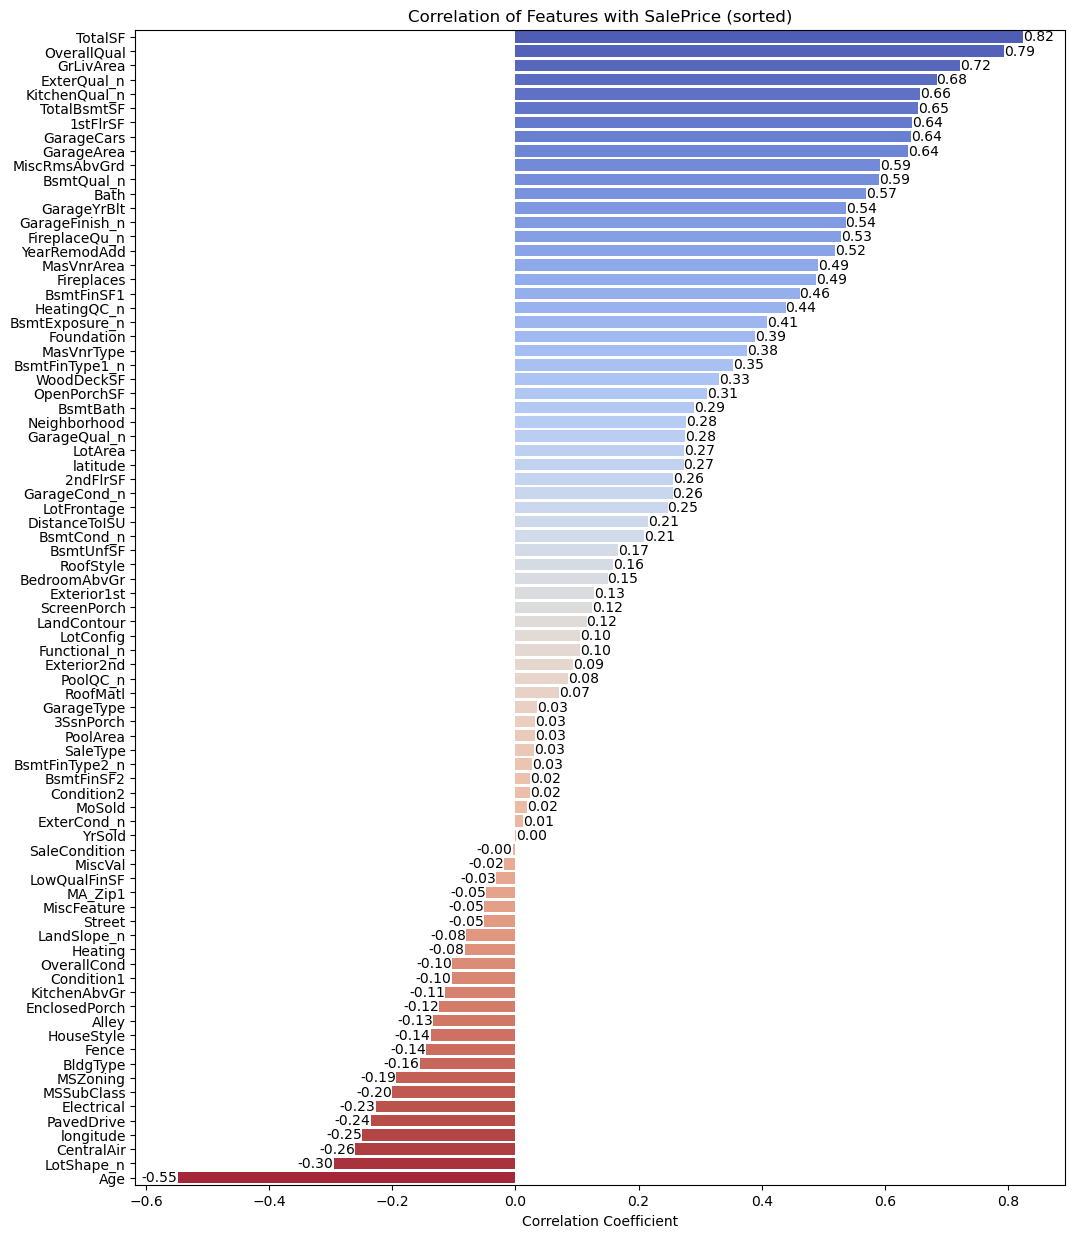

In [9]:
# Get the correlation of all features with 'SalePrice', sort them, and drop 'SalePrice'
sorted_corrs = (df_numerical.corr()['SalePrice']).sort_values(ascending=False).drop(['SalePrice'])

plt.figure(figsize=(12, 15))
sns.barplot(y=sorted_corrs.index, x=sorted_corrs.values, palette='coolwarm')
for i, value in enumerate(sorted_corrs):
    if value>0:
        plt.text(value, i, f'{value:.2f}', ha='left', va='center', color='black')#, fontweight='bold')
    else:
        plt.text(value, i, f'{value:.2f}', ha='right', va='center', color='black')#, fontweight='bold')

plt.title('Correlation of Features with SalePrice (sorted)')
plt.xlabel('Correlation Coefficient')
plt.show()

# Correlation Heat-Map

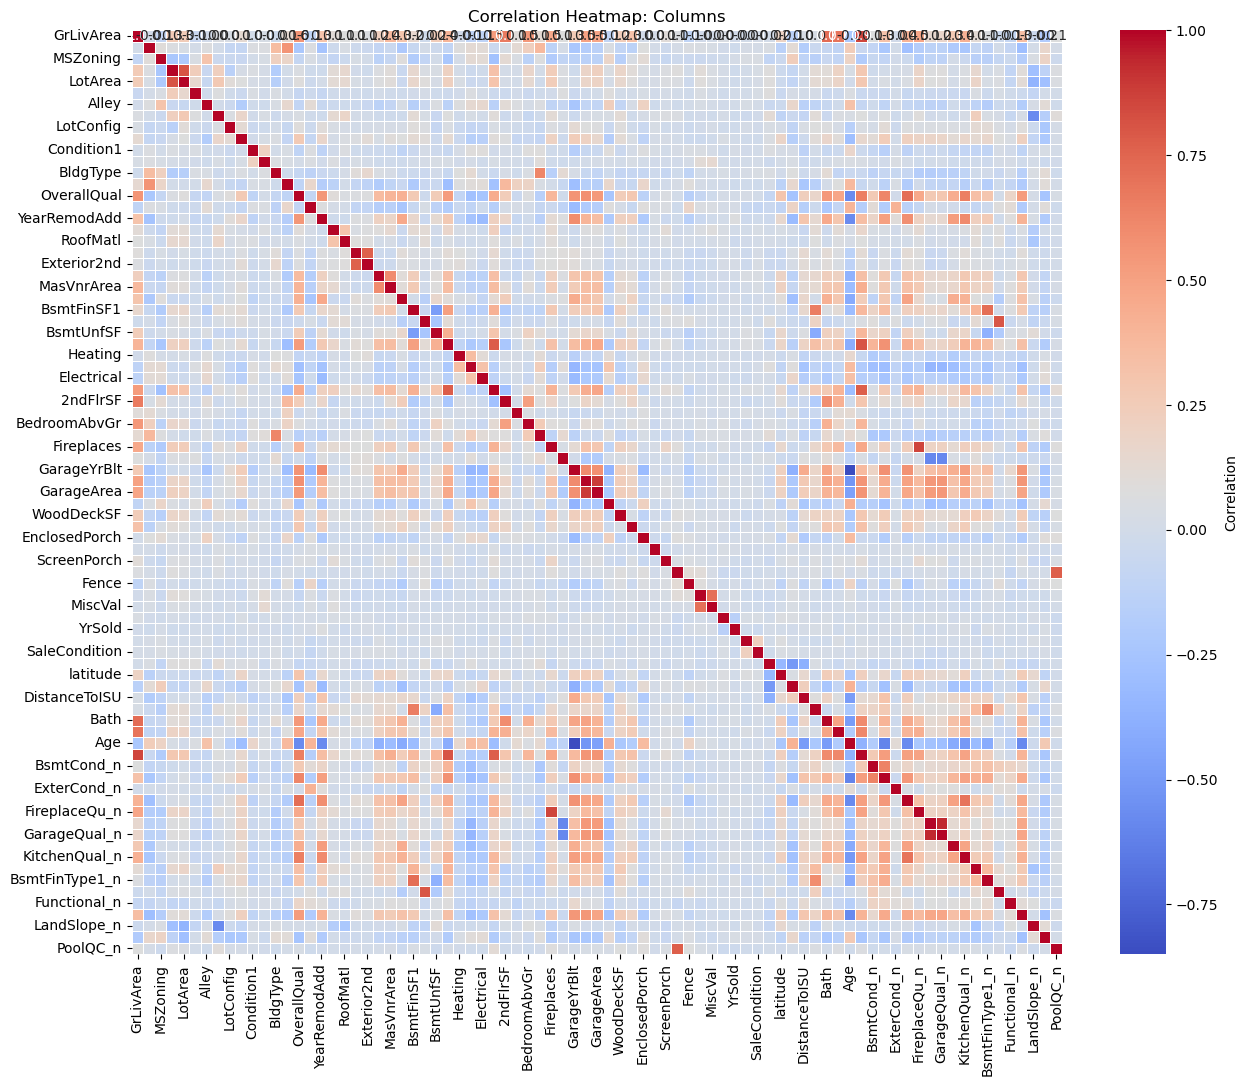

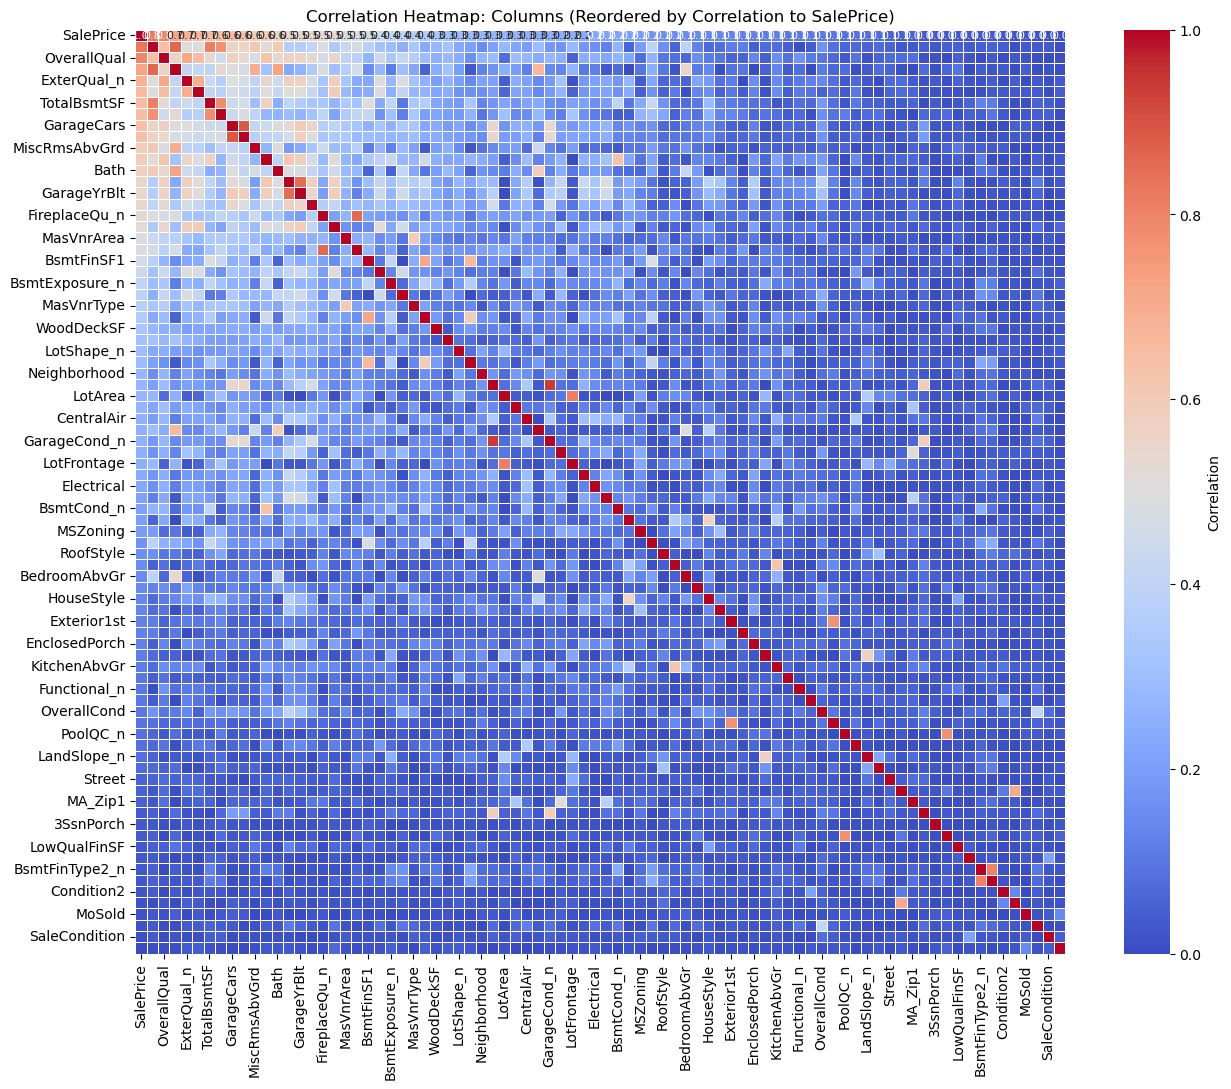

In [10]:
plt.figure(figsize=(15, 12))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(df_numerical.drop(columns=['SalePrice']).corr(), cmap=cmap, annot=True, fmt=".1f", 
                      linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap: Columns')
plt.show()

# Reorder columns based on absolute correlation to 'SalePrice'
sorted_columns = df_numerical.corr()['SalePrice'].abs().sort_values(ascending=False).index
sorted_corr_matrix = df_numerical.corr()[sorted_columns].abs().loc[sorted_columns]
plt.figure(figsize=(15, 12))
plt.title('Correlation Heatmap: Columns (Reordered by Correlation to SalePrice)')
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(sorted_corr_matrix, cmap=cmap, annot=True, fmt=".1f", 
            linewidths=0.5, cbar_kws={'label': 'Correlation'},annot_kws={'fontsize': 8})
plt.show()

# Review Seasonality

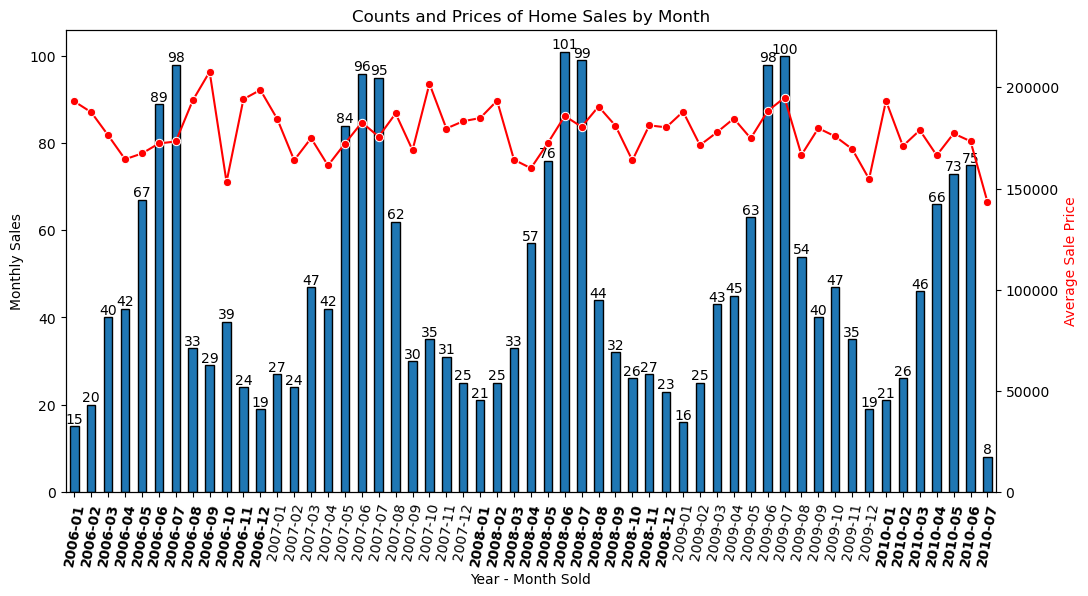

In [13]:
plot_df = housing_coords.copy()
plot_df['YrMoSold'] = plot_df['YrSold'].astype(str) + '-' + \
    plot_df['MoSold'].astype(str).str.zfill(2)

sales_by_year_month = plot_df['YrMoSold'].value_counts().sort_index()
prices_by_year_month = round(plot_df.groupby('YrMoSold')['SalePrice'].mean()).astype(int)

fig, ax1 = plt.subplots(figsize=(12, 6))
bar_plot = sales_by_year_month.plot(kind='bar', edgecolor='black')
for i, count in enumerate(sales_by_year_month):
    bar_plot.text(i, count, str(count), ha='center', va='bottom')

ax2 = ax1.twinx()
line_plot = sns.lineplot(x=prices_by_year_month.index, y=prices_by_year_month.values,
                         color='red', marker='o', ax=ax2)

ax1.set_xlabel('Year - Month Sold')
ax1.set_ylabel('Monthly Sales')
ax1.set_title('Counts and Prices of Home Sales by Month')
ax2.set_ylabel('Average Sale Price', color='red')
ax2.set_ylim(0, 1.1 * prices_by_year_month.max())

for i, tick in enumerate(ax1.get_xticklabels()):
    if (i // 12) % 2 == 0:
        tick.set_fontweight('bold')
ax1.tick_params(axis='x', rotation=80)


plt.show()

# Review changes to target by age of home when sold vs years since remodel

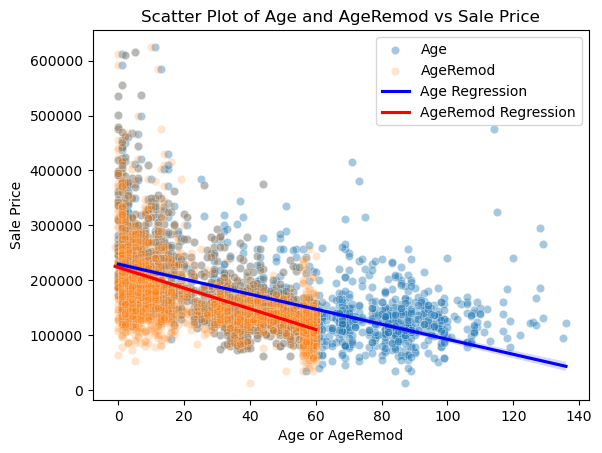

In [16]:
# Scatter plot of Age vs SalePrice
sns.scatterplot(x='Age', y='SalePrice', data=plot_df, label='Age',alpha=0.4)

# Scatter plot of AgeRemod vs SalePrice
plot_df['AgeRemod'] = plot_df['YrSold'] - plot_df['YearRemodAdd']
sns.scatterplot(x='AgeRemod', y='SalePrice', data=plot_df, label='AgeRemod',alpha=0.2)

# Add regression lines
sns.regplot(x='Age', y='SalePrice', data=plot_df, scatter=False, label='Age Regression', color='blue')
sns.regplot(x='AgeRemod', y='SalePrice', data=plot_df, scatter=False, label='AgeRemod Regression', color='red')

# Set labels and title
plt.xlabel('Age or AgeRemod')
plt.ylabel('Sale Price')
plt.title('Scatter Plot of Age and AgeRemod vs Sale Price')
plt.legend()
plt.show()

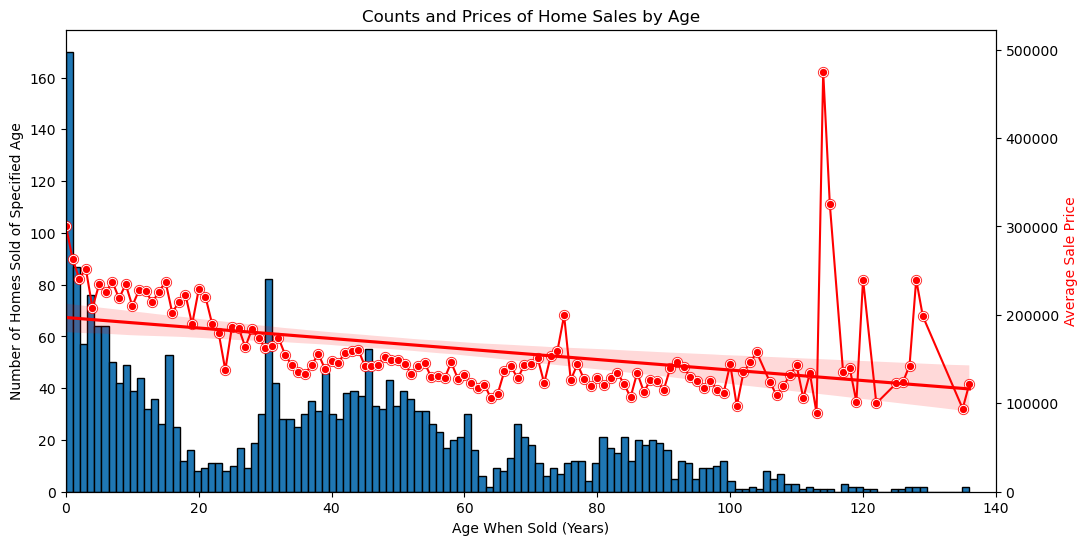

In [17]:
sales_by_age = plot_df['Age'].value_counts()
prices_by_age = round(plot_df.groupby('Age')['SalePrice'].mean()).astype(int)

bins=len(sales_by_age)
fig, ax1 = plt.subplots(figsize=(12, 6))
# bar_plot = sales_by_year_month.plot(kind='bar', edgecolor='black')
bar_plot = plt.hist(plot_df['Age'], bins=bins, edgecolor='black')

ax2 = ax1.twinx()
line_plot = sns.lineplot(x=prices_by_age.index, y=prices_by_age.values,
                         color='red', marker='o', ax=ax2)

sns.regplot(x=prices_by_age.index, y=prices_by_age.values,
            scatter_kws={'s': 50}, color='red', ax=ax2, label='Regression Line')

ax1.set_xlabel('Age When Sold (Years)')
ax1.set_ylabel('Number of Homes Sold of Specified Age')
ax1.set_title('Counts and Prices of Home Sales by Age')
ax2.set_ylabel('Average Sale Price', color='red')
ax2.set_ylim(0, 1.1 * prices_by_age.max())
ax1.set_xlim(0, 140)
ax1.tick_params(axis='x', rotation=0)

plt.show()

# Correlation between Sale Price and Distance to ISU
There is no strong correlation between distance and price, but clearly strong correlation between price and quality among the neighborhoods

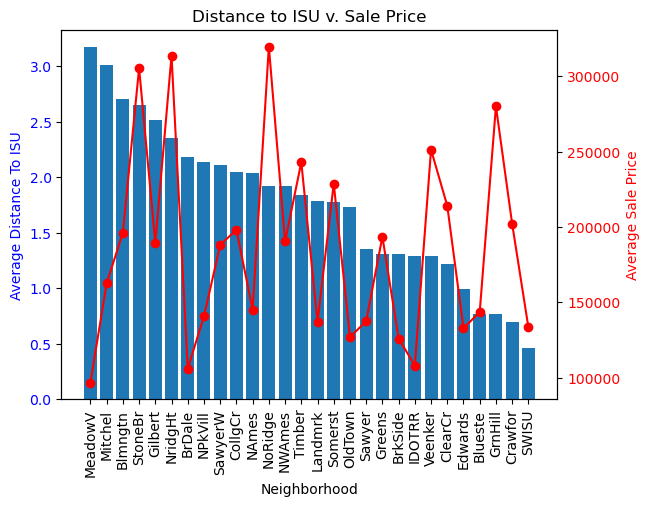

In [24]:
neighborhood_df = housing_coords.groupby('Neighborhood').agg(
    {'DistanceToISU': 'mean', 'SalePrice': 'mean', 'OverallQual':'mean'}).reset_index()
neighborhood_df = neighborhood_df.sort_values(by='DistanceToISU', ascending=False)
fig, ax1 = plt.subplots()

ax1.bar(neighborhood_df['Neighborhood'], neighborhood_df['DistanceToISU'])
ax1.set_ylabel('Average Distance To ISU', color='blue')
ax1.set_xlabel('Neighborhood')
ax1.set_title('Distance to ISU v. Sale Price')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
ax2.plot(neighborhood_df['Neighborhood'], neighborhood_df['SalePrice'], color='red', marker='o')
ax2.set_ylabel('Average Sale Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()

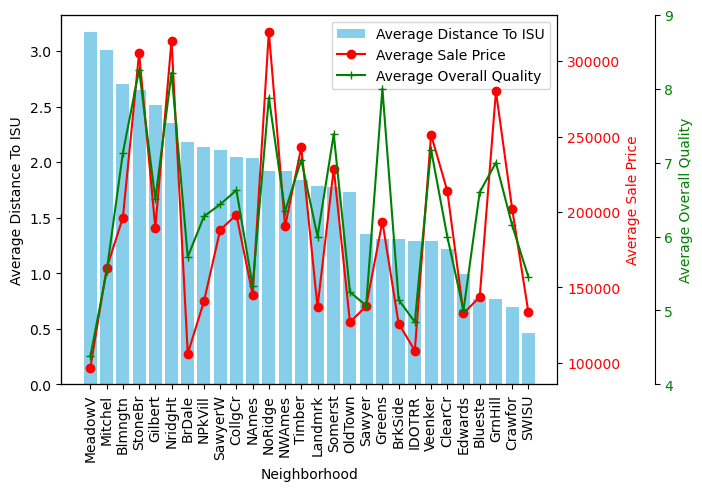

In [27]:
fig, ax1 = plt.subplots()
plot1 = ax1.bar(neighborhood_df['Neighborhood'], neighborhood_df['DistanceToISU'], 
                color='skyblue', label='Average Distance To ISU')
ax1.set_ylabel('Average Distance To ISU')
ax1.set_xlabel('Neighborhood')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
plot2 = ax2.plot(neighborhood_df['Neighborhood'], neighborhood_df['SalePrice'], 
                 color='red', marker='o', label='Average Sale Price')
ax2.set_ylabel('Average Sale Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 70))
plot3 = ax3.plot(neighborhood_df['Neighborhood'], neighborhood_df['OverallQual'], 
                 color='green', marker='+', label='Average Overall Quality')
ax3.set_ylabel('Average Overall Quality', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_ylim(4, 9)

plots = [plot1, plot2[0], plot3[0]]
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc='upper right')
plt.show()

# Create a folium map centered at the mean of coordinates for data visualization

In [29]:
map_center = [0.5*(housing_coords['latitude'].max() + housing_coords['latitude'].min()), 
              0.5*(housing_coords['longitude'].max() + housing_coords['longitude'].min())]
mymap = folium.Map(location=map_center, zoom_start=13.25)

# Get unique neighborhoods from the DataFrame
neighborhoods = list(housing_coords['Neighborhood'].unique())

# Define a color dictionary with random colors for each neighborhood
color_dict = {neighborhood: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for neighborhood in neighborhoods}

# Iterate through the DataFrame and add markers to the map
for index, row in housing_coords.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color_dict.get(row['Neighborhood'], 'gray'),
        fill=True,
        fill_color=color_dict.get(row['Neighborhood'], 'gray'),
#         fill_opacity=0.7,
        popup=row['Neighborhood'],
    ).add_to(mymap)

display(mymap)

In [30]:
# Create a Folium map centered at the mean of coordinates
map_center = [0.5 * (housing_coords['latitude'].max() + housing_coords['latitude'].min()),
              0.5 * (housing_coords['longitude'].max() + housing_coords['longitude'].min())]
mymap = folium.Map(location=map_center, zoom_start=12.5)

# Get quartile ranges for 'SalePrice'
quartiles = np.percentile(housing_coords['SalePrice'], [25, 50, 75])
min_value, max_value = housing_coords['SalePrice'].min(), housing_coords['SalePrice'].max()

# Assign colors based on quartile ranges
def assign_color(price):
    if price <= quartiles[0]:
        return 'blue'
    elif price <= quartiles[1]:
        return 'green'
    elif price <= quartiles[2]:
        return 'orange'
    else:
        return 'red'

# Legend
legend_html = f"""
    <div style="position: fixed; bottom: 50px; left: 50px; z-index:1000; font-size:14px;">
        <p><span style="background-color: blue; border-radius: 50%; padding: 5px 10px;"></span>&nbsp;1st Quartile (Min: {min_value}, Max: {quartiles[0]})</p>
        <p><span style="background-color: green; border-radius: 50%; padding: 5px 10px;"></span>&nbsp;2nd Quartile (Min: {quartiles[0]}, Max: {quartiles[1]})</p>
        <p><span style="background-color: orange; border-radius: 50%; padding: 5px 10px;"></span>&nbsp;3rd Quartile (Min: {quartiles[1]}, Max: {quartiles[2]})</p>
        <p><span style="background-color: red; border-radius: 50%; padding: 5px 10px;"></span>&nbsp;4th Quartile (Min: {quartiles[2]}, Max: {max_value})</p>
    </div>
"""

mymap.get_root().html.add_child(folium.Element(legend_html))

# Iterate through the DataFrame and add markers to the map
for index, row in housing_coords.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=assign_color(row['SalePrice']),
        fill=True,
        fill_color=assign_color(row['SalePrice']),
        fill_opacity=0.7,
        popup=row['Neighborhood'],
    ).add_to(mymap)

display(mymap)

# MLR with different types of variables

In [31]:
# Initialize an empty list to store results
results_list = []

# Create a k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

feature_columns = [['OverallQual', 'TotalSF'],  # 2 numeric
                   ['OverallQual', 'BsmtQual_n'], # 1 numeric, 1 ordinal
                   ['OverallQual', 'CentralAir'], # 1 numeric, 1 categorical
                   ['TotalSF', 'ExterQual_n']]  # 1 numeric, 1 categorical (many categories)

for i in feature_columns:
    X = housing_coords[i]
    y = housing_coords['SalePrice']
    
    if any(col in non_ordinal_columns for col in i):
        # Perform one-hot encoding for the relevant columns
        for col in i:
            if col in non_ordinal_columns:
                column_dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
                X = pd.concat([X.drop(col, axis=1), column_dummies], axis=1)
    
    # Linear Regression
    linear_model = LinearRegression()
    
    # Use cross_val_score for k-fold cross-validation
    r2_scores = cross_val_score(linear_model, X, y, scoring='r2', cv=kf)
    
    # Fit the model to obtain coefficients for each fold
    coefficients_list = []
    intercept_list = []
    for train_index, _ in kf.split(X):
        linear_model.fit(X.iloc[train_index], y.iloc[train_index])
        coefficients_list.append(linear_model.coef_)
        intercept_list.append(linear_model.intercept_)
    
    # Calculate the average coefficients across folds
    average_coefficients = round(pd.DataFrame(coefficients_list).mean(),6)
    average_intercept = pd.Series(intercept_list).mean()
    
    # Append results to the list
    results_list.append({
        'Features Used': list(i),
        'Fold 1 R2': r2_scores[0],
        'Fold 2 R2': r2_scores[1], 
        'Fold 3 R2': r2_scores[2], 
        'Fold 4 R2': r2_scores[3], 
        'Fold 5 R2': r2_scores[4], 
        'MLR Mean R2': r2_scores.mean(),
        'Standard Deviation': r2_scores.std(),
        'Average Coefficients': average_coefficients.values.tolist(),
        'Average Intercept': average_intercept
    })

pd.set_option('display.max_colwidth', None)

# Create a data frame from the list of results
results_df = pd.DataFrame(results_list)
results_df.iloc[:,[0,6,8]]

Features Used  MLR Mean R2          Average Coefficients
0     [OverallQual, TotalSF]      0.79485     [24343.383218, 52.815704]
1  [OverallQual, BsmtQual_n]      0.64297  [37850.587927, 13246.424963]
2  [OverallQual, CentralAir]      0.62996  [42517.459248, 13478.496323]
3     [TotalSF, ExterQual_n]      0.77285     [63.464694, 47541.062111]

In [68]:
# Initialize an empty list to store results
results_list2 = []

for i in range(len(corr_sorted_numerical_columns.index)):
        # Removing the columns with overlapping features Greatly lowered R2 values...
        # feature_columns = test[:10]
        # feature_columns = test2[:10]
    feature_columns = corr_sorted_numerical_columns.index[0:i+1]

    # Extract features and target variable
    X = housing_coords[feature_columns]
    y = housing_coords['SalePrice']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features (optional, but often recommended)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train)
    y_pred_linear = linear_model.predict(X_test_scaled)

    # Set up parameter grids for Ridge and Lasso
    alpha_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform GridSearchCV for Ridge
    ridge_model = Ridge()
    ridge_grid = GridSearchCV(ridge_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
    ridge_grid.fit(X_train_scaled, y_train)

    # Perform GridSearchCV for Lasso
    lasso_model = Lasso()
    lasso_grid = GridSearchCV(lasso_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
    lasso_grid.fit(X_train_scaled, y_train)

    # Get the best alpha values
    best_alpha_ridge = ridge_grid.best_params_['alpha']
    best_alpha_lasso = lasso_grid.best_params_['alpha']

    # Ridge Regression
    ridge_model_best = Ridge(alpha=best_alpha_ridge)
    ridge_model_best.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge_model_best.predict(X_test_scaled)

    # Lasso Regression
    lasso_model_best = Lasso(alpha=best_alpha_lasso)  # You can adjust the alpha parameter for regularization strength
    lasso_model_best.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso_model_best.predict(X_test_scaled)

    # Evaluate the models
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    r2_linear = r2_score(y_test, y_pred_linear)

    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)

    # print('\nLasso Coefficients:', lasso_model_best.coef_)
    # print('Lasso Intercept:', lasso_model_best.intercept_)
    
    # Append results to the list
    results_list2.append({
        'Number of Features Used': len(list(feature_columns)),
        'Linear Regression R2': r2_linear,
        'Ridge Regression R2': r2_ridge, 
        'Lasso Regression R2': r2_lasso
    })

# Create a data frame from the list of results
pd.set_option('display.max_colwidth', 50)
results_df2 = pd.DataFrame(results_list2)

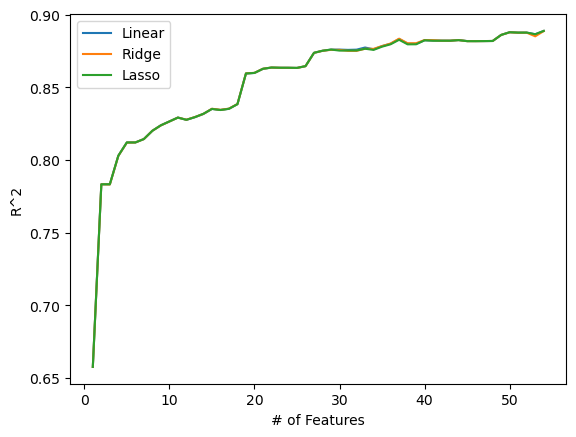

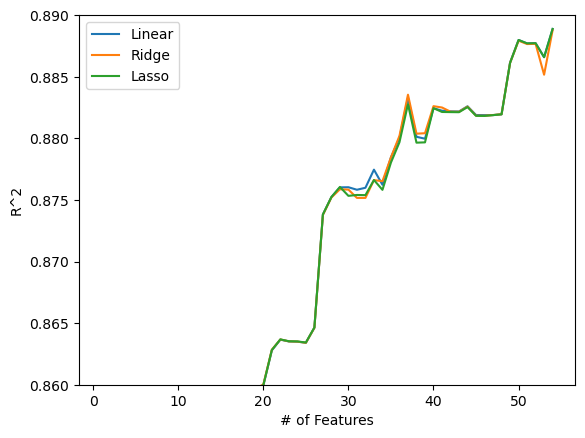

In [69]:
plt.plot(results_df2['Number of Features Used'], results_df2['Linear Regression R2'], label='Linear')
plt.plot(results_df2['Number of Features Used'], results_df2['Ridge Regression R2'], label='Ridge')
plt.plot(results_df2['Number of Features Used'], results_df2['Lasso Regression R2'], label='Lasso')

plt.xlabel('# of Features')
plt.ylabel('R^2')
plt.legend()
plt.show()

plt.plot(results_df2['Number of Features Used'], results_df2['Linear Regression R2'], label='Linear')
plt.plot(results_df2['Number of Features Used'], results_df2['Ridge Regression R2'], label='Ridge')
plt.plot(results_df2['Number of Features Used'], results_df2['Lasso Regression R2'], label='Lasso')

plt.xlabel('# of Features')
plt.ylabel('R^2')
plt.legend()
plt.ylim(.86,.89)
plt.show()

Using more and more features tends to provide higher and higher R2 values with minimal differences between penalized and non-penalized models

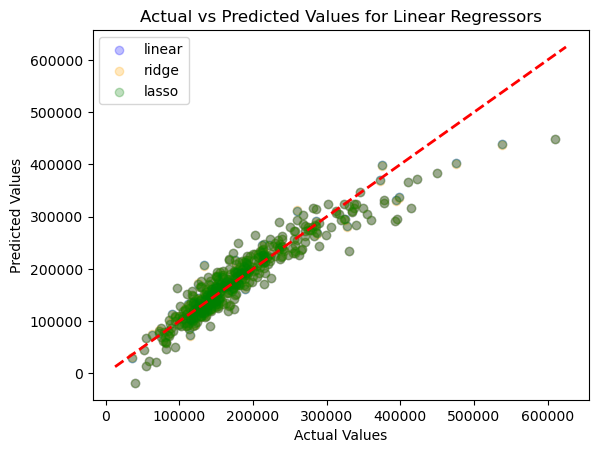

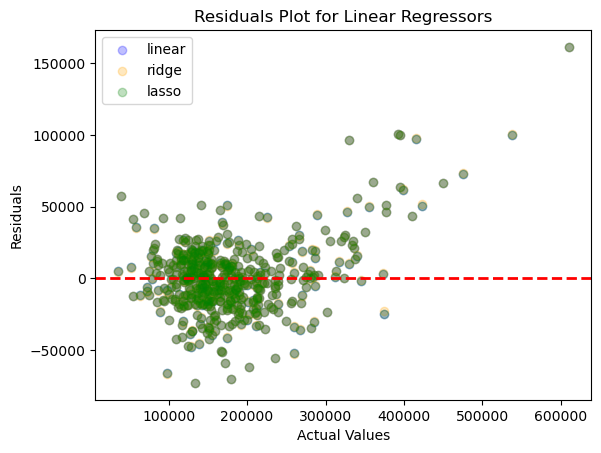

In [67]:
plt.scatter(y_test, y_pred_linear, alpha=0.25, color='blue', label='linear')
plt.scatter(y_test, y_pred_ridge, alpha=0.25, color='orange', label='ridge')
plt.scatter(y_test, y_pred_lasso, alpha=0.25, color='green', label='lasso')
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle="--", color='red', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Linear Regressors")
plt.legend()
plt.show()

residuals_linear = y_test - y_pred_linear
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso
plt.scatter(y_test, residuals_linear, alpha=0.25, color='blue', label='linear')
plt.scatter(y_test, residuals_ridge, alpha=0.25, color='orange', label='ridge')
plt.scatter(y_test, residuals_lasso, alpha=0.25, color='green', label='lasso')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot for Linear Regressors")
plt.legend()
plt.show()

Roughly same residuals for all linear models

# Basic test to see which ML model to investigate further

In [70]:
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to loop through
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    # 'LGBMRegressor': LGBMRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

# Initialize an empty list to store results
results_list3 = []

# Loop over each model
for model_name, model in models.items():
    
    # Create a pipeline with preprocessor and the current model
    full_model = Pipeline(steps=[('regressor', model)])
    
    r2_scorelist = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=99)
    
    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        full_model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = full_model.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
        MSE =  mean_squared_error(y_test, y_pred)
        MAE =  mean_absolute_error(y_test, y_pred)

        # Append results to the list
        results_list3.append({'Model': model_name, 'R2': r2, 'MSE': MSE, 'MAE': MAE})
        
        # print(f"{model_name} - Fold {fold} - R^2: {r2:.4f}")

    # Calculate and print the average R-squared across folds for the current model
    average_r2 = np.mean(r2_scorelist)
    # print(f"{model_name} - Average R^2: {average_r2:.4f}")

# Create the overall results DataFrame
results_df3 = pd.DataFrame(results_list3).groupby('Model').mean().sort_values('R2', ascending=False)
results_df3

R2             MSE         MAE
Model                                                            
GradientBoostingRegressor     0.92703 399600557.78222 13176.81917
HistGradientBoostingRegressor 0.92454 413669045.81594 12858.33696
ExtraTreesRegressor           0.91723 454027408.12039 13649.25736
XGBRegressor                  0.91551 458607222.70555 13972.52447
RandomForestRegressor         0.90901 496327398.72313 14427.60776
Lasso                         0.89256 582028189.80295 16652.67575
Linear Regression             0.89253 582175274.44554 16656.33405
Ridge                         0.89210 584595134.87604 16703.01480
ElasticNet                    0.88496 624847494.15185 16917.58553

# Gradient Boosting Regressor

## Initial Gridsearch was performed on dummified dataframe.  

#### Once the decision was made to use the numerically mapped dataframe instead this effort was scrapped but the insights gained from the grid search were used as the basis for hyperparameter tuning

This code chunk runs for approximately 3.5 hrs and returns the following:
- Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.5}
- Best R-squared: 0.9359751878898394
- R-squared on Test Data: 0.9368

In [ ]:
# start_time = time.time()

# # Separate features and target variable
# X = df_with_dummies.drop('SalePrice', axis=1)
# y = df_with_dummies['SalePrice']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# param_grid = {
#     'learning_rate': [0.1, 0.05, 0.01, 0.001],
#     'subsample': [1.0, 0.8, 0.7, 0.6, 0.5],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize the Gradient Boosting Regressor
# gb_model = GradientBoostingRegressor(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# # Perform the grid search
# grid_search.fit(X_train, y_train)

# # Print the best parameters and their corresponding R2 score
# print("Best Parameters:", grid_search.best_params_)
# print("Best R-squared:", grid_search.best_score_)

# # Get the best model
# best_gb_model = grid_search.best_estimator_

# # Make predictions on the test data using the best model
# y_pred = best_gb_model.predict(X_test)

# # Evaluate the model using R2
# r2 = r2_score(y_test, y_pred)
# print(f'R-squared on Test Data: {r2:.4f}')

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed Time: {elapsed_time:.2f} seconds")

#### This grid search was then performed after sampling different values for specific parameters to see if there could be large improvements

This code chunk runs for approximately 9.5 hrs and returns the following:
- Best Parameters: {'learning_rate': 0.008, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 6000, 'subsample': 0.3}
- Best R-squared: 0.941400438914043
- R-squared on Test Data: 0.9495

In [ ]:
# start_time = time.time()

# # Separate features and target variable
# X = df_numerical.drop('SalePrice', axis=1)
# y = df_numerical['SalePrice']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# param_grid = {
#     'learning_rate': [0.008, 0.01, 0.012],
#     'subsample': [0.2, 0.3, 0.4],
#     'n_estimators': [5000, 6000, 7000],
#     'max_depth': [3, 4, 5, 6],
#     'min_samples_split': [3, 5, 7],
#     # 'min_samples_leaf': [1, 2]
# }

# # Initialize the Gradient Boosting Regressor
# gb_model = GradientBoostingRegressor(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# # Perform the grid search
# grid_search.fit(X_train, y_train)

# # Print the best parameters and their corresponding R2 score
# print("Best Parameters:", grid_search.best_params_)
# print("Best R-squared:", grid_search.best_score_)

# # Get the best model
# best_gb_model = grid_search.best_estimator_

# # Make predictions on the test data using the best model
# y_pred = best_gb_model.predict(X_test)

# # Evaluate the model using R2
# r2 = r2_score(y_test, y_pred)
# print(f'R-squared on Test Data: {r2:.4f}')

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed Time: {elapsed_time:.2f} seconds")

#### Comparing the R^2 values when using the different hyperparameters

From the below we see that dummifing is not necessary for gradient boosting.  As long as the 1st feature is kept the scores will not be impacted greatly.

In [71]:
start_time = time.time()

results_list4 = []

gbmr = GradientBoostingRegressor()
gbmr.set_params(learning_rate=0.008, max_depth=3, min_samples_split=5, n_estimators=6000, subsample=0.3, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list4.append({
    'DataFrame': 'df_numerical',
    'Hyperparameters': 'best for numerical',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list4.append({
    'DataFrame': 'df_with_dummies',
    'Hyperparameters': 'best for numerical',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

gbmr.set_params(learning_rate=0.05, max_depth=4, min_samples_split=2, n_estimators=4000, subsample=0.5, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list4.append({
    'DataFrame': 'df_numerical',
    'Hyperparameters': 'best for dummies',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list4.append({
    'DataFrame': 'df_with_dummies',
    'Hyperparameters': 'best for dummies',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

results_df4 = pd.DataFrame(results_list4)
results_df4

Elapsed Time: 90.70 seconds
Elapsed Time: 193.75 seconds
Elapsed Time: 316.29 seconds
Elapsed Time: 459.74 seconds


DataFrame     Hyperparameters  Fold 1 R2  Fold 2 R2  Fold 3 R2  \
0     df_numerical  best for numerical    0.94646    0.93912    0.95445   
1  df_with_dummies  best for numerical    0.94787    0.94144    0.95584   
2     df_numerical    best for dummies    0.94283    0.93457    0.94317   
3  df_with_dummies    best for dummies    0.94387    0.93625    0.94926   

   Fold 4 R2  Fold 5 R2  MLR Mean R2  Standard Deviation  
0    0.94875    0.93245      0.94424             0.00768  
1    0.94682    0.92937      0.94427             0.00875  
2    0.94421    0.92979      0.93892             0.00572  
3    0.94060    0.92350      0.93870             0.00871

## Redefine X + y + test/train split

In [82]:
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Various Features sampled

### Null Model (for baseline)

In [85]:
# Approximate total time = 382 seconds
start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr_results_list = []
n_estimators_values = list(range(100, 9001, 1000))

for n_estimators in n_estimators_values:
    gbmr.set_params(n_estimators=n_estimators)
    r2_scorelist = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        start_time2 = time.time()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        gbmr.fit(X_train, y_train)
        y_pred = gbmr.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
        
        mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
        gbmr_results_list.append({'MeanR2': mean_r2, 'n_estimators':n_estimators})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"n_estimators {n_estimators} Completed. Total Elapsed Time: {elapsed_time:.2f} seconds")

results_df_temp = pd.DataFrame(gbmr_results_list)

n_estimators 100 Completed. Total Elapsed Time: 4.42 seconds
n_estimators 1100 Completed. Total Elapsed Time: 53.71 seconds
n_estimators 2100 Completed. Total Elapsed Time: 148.13 seconds
n_estimators 3100 Completed. Total Elapsed Time: 286.84 seconds
n_estimators 4100 Completed. Total Elapsed Time: 464.10 seconds
n_estimators 5100 Completed. Total Elapsed Time: 683.19 seconds
n_estimators 6100 Completed. Total Elapsed Time: 944.51 seconds
n_estimators 7100 Completed. Total Elapsed Time: 1248.79 seconds
n_estimators 8100 Completed. Total Elapsed Time: 1600.91 seconds


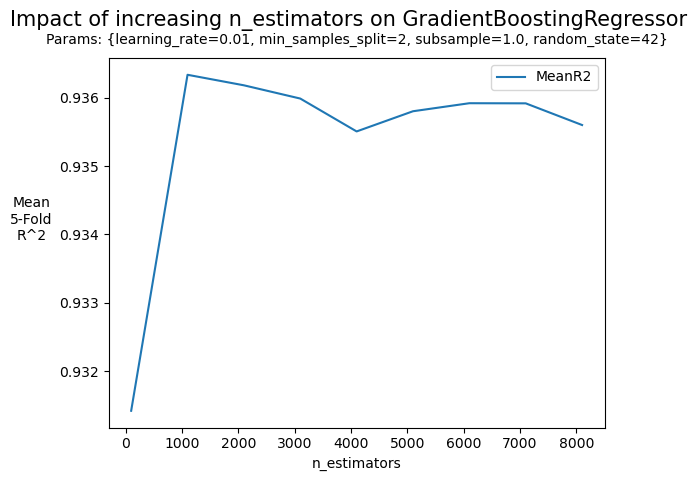

In [93]:
gmbr_df = results_df_temp.groupby('n_estimators').mean()
gmbr_df.plot(linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.suptitle('Impact of increasing n_estimators on GradientBoostingRegressor', fontsize=15)
plt.title('Params: {learning_rate=0.01, min_samples_split=2, subsample=1.0, random_state=42}', fontsize=10, pad=10)
plt.show()

In [100]:
housing_coords.MA_Zip1.value_counts()

MA_Zip1
50010    1535
50014     831
other     211
Name: count, dtype: int64